In [1]:
!pip install datasets --quiet
!pip install transformers --quiet
!pip install gensim==3.8.3 --quiet
!pip install -U tensorflow_text==2.8.2 --quiet
!pip install tensorflow-datasets --quiet
!pip install pydot --quiet
!pip install tensorflow==2.8.2 --quiet

     |████████████████████████████████| 451 kB 9.8 MB/s 
     |████████████████████████████████| 212 kB 36.8 MB/s 
     |████████████████████████████████| 115 kB 53.3 MB/s 
     |████████████████████████████████| 182 kB 34.9 MB/s 
     |████████████████████████████████| 127 kB 34.6 MB/s 
     |████████████████████████████████| 5.5 MB 15.1 MB/s 
     |████████████████████████████████| 7.6 MB 55.0 MB/s 
     |████████████████████████████████| 24.2 MB 1.4 MB/s 
     |████████████████████████████████| 4.9 MB 15.7 MB/s 
     |████████████████████████████████| 497.9 MB 4.0 kB/s 
     |████████████████████████████████| 1.4 MB 59.9 MB/s 
     |████████████████████████████████| 462 kB 73.0 MB/s 
     |████████████████████████████████| 5.8 MB 58.3 MB/s 
     |████████████████████████████████| 437.8 MB 40 kB/s 


In [2]:
import os
import nltk
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
import tensorflow as tf
import tensorflow.keras.backend as K
import tensorflow_datasets as tfds
import tensorflow_text as tf_text
import pandas as pd
import transformers
import gensim
from datasets import load_dataset

from tensorflow import keras
from tensorflow.keras.layers import Embedding, Input, Dense, Lambda
from pprint import pprint 
from datasets import load_dataset
from nltk.corpus import reuters
from nltk.data import find
from tensorflow.keras.models import Model
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
from collections import Counter
from transformers import BertTokenizer, TFBertModel

In [3]:
url = 'https://raw.githubusercontent.com/t-davidson/hate-speech-and-offensive-language/master/data/labeled_data.csv'
df = pd.read_csv(url, index_col=0)
df

,count,hate_speech,offensive_language,neither,class,tweet
0,3,0,0,3,2,!!! RT @mayasolovely: As a woman you shouldn't...
1,3,0,3,0,1,!!!!! RT @mleew17: boy dats cold...tyga dwn ba...
2,3,0,3,0,1,!!!!!!! RT @UrKindOfBrand Dawg!!!! RT @80sbaby...
3,3,0,2,1,1,!!!!!!!!! RT @C_G_Anderson: @viva_based she lo...
4,6,0,6,0,1,!!!!!!!!!!!!! RT @ShenikaRoberts: The shit you...
...,...,...,...,...,...,...
25291,3,0,2,1,1,you's a muthaf***in lie &#8220;@LifeAsKing: @2...
25292,3,0,1,2,2,"you've gone and broke the wrong heart baby, an..."
25294,3,0,3,0,1,young buck wanna eat!!.. dat nigguh like I ain...
25295,6,0,6,0,1,youu got wild bitches tellin you lies


# Field Description from  Davidson et.al github

count = number of CrowdFlower users who coded each tweet (min is 3, sometimes more users coded a tweet when judgments were determined to be unreliable by CF).

hate_speech = number of CF users who judged the tweet to be hate speech.

offensive_language = number of CF users who judged the tweet to be offensive.

neither = number of CF users who judged the tweet to be neither offensive nor non-offensive.

class = class label for majority of CF users. 0 - hate speech 1 - offensive language 2 - neither

In [4]:
df.describe()

,count,hate_speech,offensive_language,neither,class
count,24783.000000,24783.000000,24783.000000,24783.000000,24783.000000
mean,3.243473,0.280515,2.413711,0.549247,1.110277
std,0.883060,0.631851,1.399459,1.113299,0.462089
min,3.000000,0.000000,0.000000,0.000000,0.000000
25%,3.000000,0.000000,2.000000,0.000000,1.000000
50%,3.000000,0.000000,3.000000,0.000000,1.000000
75%,3.000000,0.000000,3.000000,0.000000,1.000000
max,9.000000,7.000000,9.000000,9.000000,2.000000


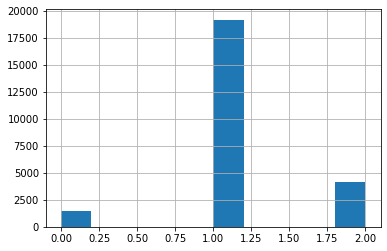

In [5]:
df['class'].hist()

In [6]:
df['tweet'].head()

0    !!! RT @mayasolovely: As a woman you shouldn't...
1    !!!!! RT @mleew17: boy dats cold...tyga dwn ba...
2    !!!!!!! RT @UrKindOfBrand Dawg!!!! RT @80sbaby...
3    !!!!!!!!! RT @C_G_Anderson: @viva_based she lo...
4    !!!!!!!!!!!!! RT @ShenikaRoberts: The shit you...
Name: tweet, dtype: object

Light Data Cleaning

In [7]:
df['tweet'][0].split(": ")[1:]

["As a woman you shouldn't complain about cleaning up your house. &amp; as a man you should always take the trash out..."]

In [8]:
# Remove the initial exclamation points and the RT twitter handles
df['tweet'] = df['tweet'].apply(lambda x: ": ".join(x.split(": ")[1:]) if len(x.split(": ")) > 1 else x)
df['tweet']

0        As a woman you shouldn't complain about cleani...
1        boy dats cold...tyga dwn bad for cuffin dat ho...
2        You ever fuck a bitch and she start to cry? Yo...
3                       @viva_based she look like a tranny
4        The shit you hear about me might be true or it...
                               ...                        
25291    @20_Pearls @corey_emanuel right! His TL is tra...
25292    you've gone and broke the wrong heart baby, an...
25294    young buck wanna eat!!.. dat nigguh like I ain...
25295                youu got wild bitches tellin you lies
25296    ~~Ruffled | Ntac Eileen Dahlia - Beautiful col...
Name: tweet, Length: 24783, dtype: object

In [9]:
# remove the unicode symbols 
import re
df['tweet'] = df['tweet'].apply(lambda x: re.sub("&#\d+","",x))

# remove other @handles 
df['tweet'] = df['tweet'].apply(lambda x: re.sub("@[^ ]+ ","",x))
df['tweet']

0        As a woman you shouldn't complain about cleani...
1        boy dats cold...tyga dwn bad for cuffin dat ho...
2        You ever fuck a bitch and she start to cry? Yo...
3                                   she look like a tranny
4        The shit you hear about me might be true or it...
                               ...                        
25291    right! His TL is trash ;. Now, mine? Bible scr...
25292    you've gone and broke the wrong heart baby, an...
25294    young buck wanna eat!!.. dat nigguh like I ain...
25295                youu got wild bitches tellin you lies
25296    ~~Ruffled | Ntac Eileen Dahlia - Beautiful col...
Name: tweet, Length: 24783, dtype: object

In [10]:
df

,count,hate_speech,offensive_language,neither,class,tweet
0,3,0,0,3,2,As a woman you shouldn't complain about cleani...
1,3,0,3,0,1,boy dats cold...tyga dwn bad for cuffin dat ho...
2,3,0,3,0,1,You ever fuck a bitch and she start to cry? Yo...
3,3,0,2,1,1,she look like a tranny
4,6,0,6,0,1,The shit you hear about me might be true or it...
...,...,...,...,...,...,...
25291,3,0,2,1,1,"right! His TL is trash ;. Now, mine? Bible scr..."
25292,3,0,1,2,2,"you've gone and broke the wrong heart baby, an..."
25294,3,0,3,0,1,young buck wanna eat!!.. dat nigguh like I ain...
25295,6,0,6,0,1,youu got wild bitches tellin you lies


Very large skew towards offensive langauge in the dataset

In [11]:
training_tweets, testing_tweets = train_test_split(df, test_size=0.2, random_state=25, stratify = df['class'])
valid_tweets, testing_tweets = train_test_split(testing_tweets, test_size = 0.5, random_state=25, stratify = testing_tweets['class'])

In [12]:
print(f"No. of training examples: {training_tweets.shape[0]}")
print(f"No. of validation examples: {valid_tweets.shape[0]}")
print(f"No. of testing examples: {testing_tweets.shape[0]}")

No. of training examples: 19826
No. of validation examples: 2478
No. of testing examples: 2479


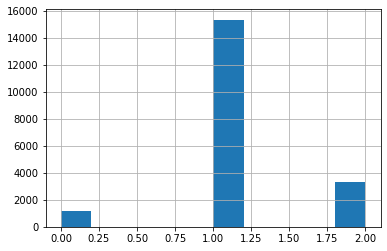

In [13]:
training_tweets['class'].hist()

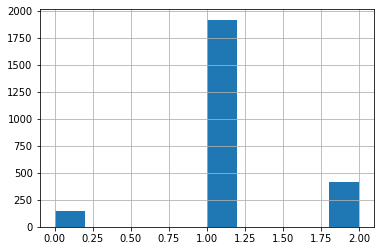

In [14]:
valid_tweets['class'].hist()

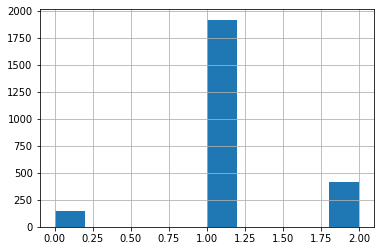

In [15]:
testing_tweets['class'].hist()

In [16]:
# get average length of tweets in the various sets
print("Average word length")
print(training_tweets['tweet'].apply(lambda x: len(x.split(' '))).mean())
print(valid_tweets['tweet'].apply(lambda x: len(x.split(' '))).mean())
print(testing_tweets['tweet'].apply(lambda x: len(x.split(' '))).mean())
print("Min max word length")
print(training_tweets['tweet'].apply(lambda x: len(x.split(' '))).min())
print(training_tweets['tweet'].apply(lambda x: len(x.split(' '))).max())

print("Average character length")
print(training_tweets['tweet'].apply(lambda x: len(x)).mean())
print(valid_tweets['tweet'].apply(lambda x: len(x)).mean())
print(testing_tweets['tweet'].apply(lambda x: len(x)).mean())

print("Min max character length")
print(training_tweets['tweet'].apply(lambda x: len(x)).min())
print(training_tweets['tweet'].apply(lambda x: len(x)).max())

Average word length
12.859427015030768
12.792171105730429
12.939491730536506
Min max word length
1
36
Average character length
68.69106224150106
68.10290556900726
68.71803146430013
Min max character length
1
148


In [17]:
max_length = 80

In [18]:
url = 'https://raw.githubusercontent.com/t-davidson/hate-speech-and-offensive-language/master/data/labeled_data.csv'
df = pd.read_csv(url, index_col=0)
df

,count,hate_speech,offensive_language,neither,class,tweet
0,3,0,0,3,2,!!! RT @mayasolovely: As a woman you shouldn't...
1,3,0,3,0,1,!!!!! RT @mleew17: boy dats cold...tyga dwn ba...
2,3,0,3,0,1,!!!!!!! RT @UrKindOfBrand Dawg!!!! RT @80sbaby...
3,3,0,2,1,1,!!!!!!!!! RT @C_G_Anderson: @viva_based she lo...
4,6,0,6,0,1,!!!!!!!!!!!!! RT @ShenikaRoberts: The shit you...
...,...,...,...,...,...,...
25291,3,0,2,1,1,you's a muthaf***in lie &#8220;@LifeAsKing: @2...
25292,3,0,1,2,2,"you've gone and broke the wrong heart baby, an..."
25294,3,0,3,0,1,young buck wanna eat!!.. dat nigguh like I ain...
25295,6,0,6,0,1,youu got wild bitches tellin you lies


# Field Description from  Davidson et.al github

count = number of CrowdFlower users who coded each tweet (min is 3, sometimes more users coded a tweet when judgments were determined to be unreliable by CF).

hate_speech = number of CF users who judged the tweet to be hate speech.

offensive_language = number of CF users who judged the tweet to be offensive.

neither = number of CF users who judged the tweet to be neither offensive nor non-offensive.

class = class label for majority of CF users. 0 - hate speech 1 - offensive language 2 - neither

In [19]:
df.describe()

,count,hate_speech,offensive_language,neither,class
count,24783.000000,24783.000000,24783.000000,24783.000000,24783.000000
mean,3.243473,0.280515,2.413711,0.549247,1.110277
std,0.883060,0.631851,1.399459,1.113299,0.462089
min,3.000000,0.000000,0.000000,0.000000,0.000000
25%,3.000000,0.000000,2.000000,0.000000,1.000000
50%,3.000000,0.000000,3.000000,0.000000,1.000000
75%,3.000000,0.000000,3.000000,0.000000,1.000000
max,9.000000,7.000000,9.000000,9.000000,2.000000


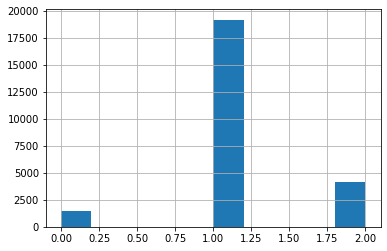

In [20]:
df['class'].hist()

In [21]:
df['tweet'].head()

0    !!! RT @mayasolovely: As a woman you shouldn't...
1    !!!!! RT @mleew17: boy dats cold...tyga dwn ba...
2    !!!!!!! RT @UrKindOfBrand Dawg!!!! RT @80sbaby...
3    !!!!!!!!! RT @C_G_Anderson: @viva_based she lo...
4    !!!!!!!!!!!!! RT @ShenikaRoberts: The shit you...
Name: tweet, dtype: object

Light Data Cleaning

In [22]:
df['tweet'][0].split(": ")[1:]

["As a woman you shouldn't complain about cleaning up your house. &amp; as a man you should always take the trash out..."]

In [23]:
# Remove the initial exclamation points and the RT twitter handles
df['tweet'] = df['tweet'].apply(lambda x: ": ".join(x.split(": ")[1:]) if len(x.split(": ")) > 1 else x)
df['tweet']

0        As a woman you shouldn't complain about cleani...
1        boy dats cold...tyga dwn bad for cuffin dat ho...
2        You ever fuck a bitch and she start to cry? Yo...
3                       @viva_based she look like a tranny
4        The shit you hear about me might be true or it...
                               ...                        
25291    @20_Pearls @corey_emanuel right! His TL is tra...
25292    you've gone and broke the wrong heart baby, an...
25294    young buck wanna eat!!.. dat nigguh like I ain...
25295                youu got wild bitches tellin you lies
25296    ~~Ruffled | Ntac Eileen Dahlia - Beautiful col...
Name: tweet, Length: 24783, dtype: object

In [24]:
# remove the unicode symbols 
import re
df['tweet'] = df['tweet'].apply(lambda x: re.sub("&#\d+","",x))

# remove other @handles 
df['tweet'] = df['tweet'].apply(lambda x: re.sub("@[^ ]+ ","",x))
df['tweet']

0        As a woman you shouldn't complain about cleani...
1        boy dats cold...tyga dwn bad for cuffin dat ho...
2        You ever fuck a bitch and she start to cry? Yo...
3                                   she look like a tranny
4        The shit you hear about me might be true or it...
                               ...                        
25291    right! His TL is trash ;. Now, mine? Bible scr...
25292    you've gone and broke the wrong heart baby, an...
25294    young buck wanna eat!!.. dat nigguh like I ain...
25295                youu got wild bitches tellin you lies
25296    ~~Ruffled | Ntac Eileen Dahlia - Beautiful col...
Name: tweet, Length: 24783, dtype: object

In [25]:
df

,count,hate_speech,offensive_language,neither,class,tweet
0,3,0,0,3,2,As a woman you shouldn't complain about cleani...
1,3,0,3,0,1,boy dats cold...tyga dwn bad for cuffin dat ho...
2,3,0,3,0,1,You ever fuck a bitch and she start to cry? Yo...
3,3,0,2,1,1,she look like a tranny
4,6,0,6,0,1,The shit you hear about me might be true or it...
...,...,...,...,...,...,...
25291,3,0,2,1,1,"right! His TL is trash ;. Now, mine? Bible scr..."
25292,3,0,1,2,2,"you've gone and broke the wrong heart baby, an..."
25294,3,0,3,0,1,young buck wanna eat!!.. dat nigguh like I ain...
25295,6,0,6,0,1,youu got wild bitches tellin you lies


Very large skew towards offensive langauge in the dataset

In [26]:
training_tweets, testing_tweets = train_test_split(df, test_size=0.2, random_state=25, stratify = df['class'])
valid_tweets, testing_tweets = train_test_split(testing_tweets, test_size = 0.5, random_state=25, stratify = testing_tweets['class'])

In [27]:
print(f"No. of training examples: {training_tweets.shape[0]}")
print(f"No. of validation examples: {valid_tweets.shape[0]}")
print(f"No. of testing examples: {testing_tweets.shape[0]}")

No. of training examples: 19826
No. of validation examples: 2478
No. of testing examples: 2479


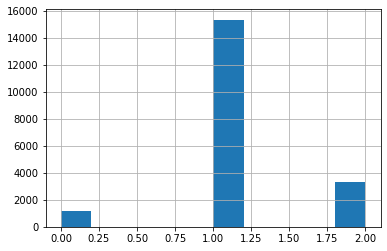

In [28]:
training_tweets['class'].hist()

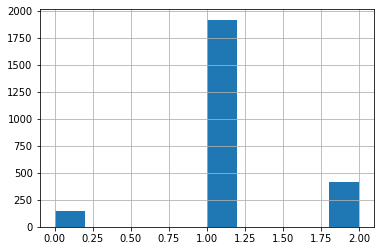

In [29]:
valid_tweets['class'].hist()

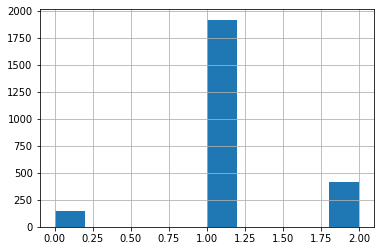

In [30]:
testing_tweets['class'].hist()

In [31]:
# get average length of tweets in the various sets
print("Average word length")
print(training_tweets['tweet'].apply(lambda x: len(x.split(' '))).mean())
print(valid_tweets['tweet'].apply(lambda x: len(x.split(' '))).mean())
print(testing_tweets['tweet'].apply(lambda x: len(x.split(' '))).mean())
print("Min max word length")
print(training_tweets['tweet'].apply(lambda x: len(x.split(' '))).min())
print(training_tweets['tweet'].apply(lambda x: len(x.split(' '))).max())

print("Average character length")
print(training_tweets['tweet'].apply(lambda x: len(x)).mean())
print(valid_tweets['tweet'].apply(lambda x: len(x)).mean())
print(testing_tweets['tweet'].apply(lambda x: len(x)).mean())

print("Min max character length")
print(training_tweets['tweet'].apply(lambda x: len(x)).min())
print(training_tweets['tweet'].apply(lambda x: len(x)).max())

Average word length
12.859427015030768
12.792171105730429
12.939491730536506
Min max word length
1
36
Average character length
68.69106224150106
68.10290556900726
68.71803146430013
Min max character length
1
148


In [32]:
max_length = 80

In [33]:
model_checkpoint = 'vinai/bertweet-base'

In [34]:
import torch
from transformers import AutoModel, AutoTokenizer, TFAutoModel

bertweet = TFAutoModel.from_pretrained(model_checkpoint)

Downloading:   0%|          | 0.00/558 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/740M [00:00<?, ?B/s]

Some layers from the model checkpoint at vinai/bertweet-base were not used when initializing TFRobertaModel: ['lm_head']
- This IS expected if you are initializing TFRobertaModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFRobertaModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
All the layers of TFRobertaModel were initialized from the model checkpoint at vinai/bertweet-base.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFRobertaModel for predictions without further training.


In [35]:
tokenizer = AutoTokenizer.from_pretrained(model_checkpoint, use_fast=False)

Downloading:   0%|          | 0.00/843k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/1.08M [00:00<?, ?B/s]

emoji is not installed, thus not converting emoticons or emojis into text. Install emoji: pip3 install emoji==0.6.0
Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.


In [36]:
# tokenize the dataset, truncate when passed `max_length`, 
# and pad with 0's when less than `max_length` and return a tf Tensor
train_encodings = tokenizer(list(training_tweets['tweet']), truncation=True, padding=True, max_length=max_length, return_tensors='tf')
valid_encodings = tokenizer(list(valid_tweets['tweet']), truncation=True, padding=True, max_length=max_length, return_tensors='tf')
test_encodings = tokenizer(list(testing_tweets['tweet']), truncation=True, padding=True, max_length=max_length, return_tensors='tf')

In [37]:
def create_bert_multiclass_model(checkpoint = model_checkpoint,
                                hidden_size = 91, 
                                dropout=0.3,
                                learning_rate=0.00005):
  """
  Build a simple classification model with BERT. Use the Pooled Output for classification purposes.
  """
  bert_model = TFBertModel.from_pretrained(checkpoint)                                              
  ### YOUR CODE HERE

  input_ids = tf.keras.layers.Input(shape=(max_length,), dtype=tf.int64, name='input_ids_layer')
  token_type_ids = tf.keras.layers.Input(shape=(max_length,), dtype=tf.int64, name='token_type_ids_layer')
  attention_mask = tf.keras.layers.Input(shape=(max_length,), dtype=tf.int64, name='attention_mask_layer')

  bert_inputs = {'input_ids': input_ids,
  'token_type_ids': token_type_ids,
  'attention_mask': attention_mask
  }      

  bert_out = bert_model(bert_inputs)

  pooled_token = bert_out[1]

  hidden = tf.keras.layers.Dense(hidden_size, activation='relu', name='hidden_layer')(pooled_token)


  hidden = tf.keras.layers.Dropout(dropout)(hidden)  


  classification = tf.keras.layers.Dense(3, activation='softmax',name='classification_layer')(hidden)

  classification_model = tf.keras.Model(inputs=[input_ids, token_type_ids, attention_mask], outputs=[classification])

  classification_model.compile(
      optimizer=tf.keras.optimizers.Adam(learning_rate=learning_rate),
      loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False), 
      metrics=['accuracy'])


  ### END YOUR CODE
  return classification_model

In [38]:
hidden_size_list = [3,10,50,80,100]
for hidden_size in hidden_size_list:
  pooled_bert_model = create_bert_multiclass_model(checkpoint = model_checkpoint, hidden_size = hidden_size)
  pooled_bert_model_history = pooled_bert_model.fit([train_encodings.input_ids, train_encodings.token_type_ids, train_encodings.attention_mask], 
                                                  np.array(training_tweets['class']),   
                                                  validation_data=([valid_encodings.input_ids, valid_encodings.token_type_ids, valid_encodings.attention_mask], 
                                                  np.array(valid_tweets['class'])),    
                                                  batch_size=32, 
                                                  epochs=1) 
  score = pooled_bert_model.evaluate([test_encodings.input_ids, test_encodings.token_type_ids, test_encodings.attention_mask], 
                                                  np.array(testing_tweets['class'])) 

  print('Test loss:', score[0]) 
  print('Test accuracy:', score[1]) 

You are using a model of type roberta to instantiate a model of type bert. This is not supported for all configurations of models and can yield errors.
Some layers from the model checkpoint at vinai/bertweet-base were not used when initializing TFBertModel: ['roberta', 'lm_head']
- This IS expected if you are initializing TFBertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFBertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some layers of TFBertModel were not initialized from the model checkpoint at vinai/bertweet-base and are newly initialized: ['bert']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


78/78 [==============================] - 14s 177ms/step - loss: 1.0726 - accuracy: 0.7741
Test loss: 1.0725598335266113
Test accuracy: 0.7741024494171143


You are using a model of type roberta to instantiate a model of type bert. This is not supported for all configurations of models and can yield errors.
Some layers from the model checkpoint at vinai/bertweet-base were not used when initializing TFBertModel: ['roberta', 'lm_head']
- This IS expected if you are initializing TFBertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFBertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some layers of TFBertModel were not initialized from the model checkpoint at vinai/bertweet-base and are newly initialized: ['bert']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


78/78 [==============================] - 14s 183ms/step - loss: 0.7266 - accuracy: 0.7741
Test loss: 0.7265723943710327
Test accuracy: 0.7741024494171143


You are using a model of type roberta to instantiate a model of type bert. This is not supported for all configurations of models and can yield errors.
Some layers from the model checkpoint at vinai/bertweet-base were not used when initializing TFBertModel: ['roberta', 'lm_head']
- This IS expected if you are initializing TFBertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFBertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some layers of TFBertModel were not initialized from the model checkpoint at vinai/bertweet-base and are newly initialized: ['bert']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


78/78 [==============================] - 14s 173ms/step - loss: 0.4101 - accuracy: 0.8592
Test loss: 0.41011226177215576
Test accuracy: 0.8592174053192139


You are using a model of type roberta to instantiate a model of type bert. This is not supported for all configurations of models and can yield errors.
Some layers from the model checkpoint at vinai/bertweet-base were not used when initializing TFBertModel: ['roberta', 'lm_head']
- This IS expected if you are initializing TFBertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFBertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some layers of TFBertModel were not initialized from the model checkpoint at vinai/bertweet-base and are newly initialized: ['bert']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


78/78 [==============================] - 14s 173ms/step - loss: 0.4229 - accuracy: 0.8560
Test loss: 0.42287343740463257
Test accuracy: 0.8559902906417847


You are using a model of type roberta to instantiate a model of type bert. This is not supported for all configurations of models and can yield errors.
Some layers from the model checkpoint at vinai/bertweet-base were not used when initializing TFBertModel: ['roberta', 'lm_head']
- This IS expected if you are initializing TFBertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFBertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some layers of TFBertModel were not initialized from the model checkpoint at vinai/bertweet-base and are newly initialized: ['bert']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


78/78 [==============================] - 14s 173ms/step - loss: 0.4178 - accuracy: 0.8637
Test loss: 0.4178287982940674
Test accuracy: 0.8636546730995178


In [42]:
dropout_size_list = [0.1,0.3,0.5,0.8]
for dropout_size in dropout_size_list:
  pooled_bert_model = create_bert_multiclass_model(checkpoint = model_checkpoint, hidden_size = 100, dropout=dropout_size)
  pooled_bert_model_history = pooled_bert_model.fit([train_encodings.input_ids, train_encodings.token_type_ids, train_encodings.attention_mask], 
                                                  np.array(training_tweets['class']),   
                                                  validation_data=([valid_encodings.input_ids, valid_encodings.token_type_ids, valid_encodings.attention_mask], 
                                                  np.array(valid_tweets['class'])),    
                                                  batch_size=32, 
                                                  epochs=1) 
  score = pooled_bert_model.evaluate([test_encodings.input_ids, test_encodings.token_type_ids, test_encodings.attention_mask], 
                                                  np.array(testing_tweets['class'])) 

  print('Test loss:', score[0]) 
  print('Test accuracy:', score[1]) 

You are using a model of type roberta to instantiate a model of type bert. This is not supported for all configurations of models and can yield errors.
Some layers from the model checkpoint at vinai/bertweet-base were not used when initializing TFBertModel: ['roberta', 'lm_head']
- This IS expected if you are initializing TFBertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFBertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some layers of TFBertModel were not initialized from the model checkpoint at vinai/bertweet-base and are newly initialized: ['bert']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


78/78 [==============================] - 14s 179ms/step - loss: 0.3734 - accuracy: 0.8790
Test loss: 0.3734179735183716
Test accuracy: 0.8789834380149841


You are using a model of type roberta to instantiate a model of type bert. This is not supported for all configurations of models and can yield errors.
Some layers from the model checkpoint at vinai/bertweet-base were not used when initializing TFBertModel: ['roberta', 'lm_head']
- This IS expected if you are initializing TFBertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFBertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some layers of TFBertModel were not initialized from the model checkpoint at vinai/bertweet-base and are newly initialized: ['bert']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


78/78 [==============================] - 14s 173ms/step - loss: 0.4493 - accuracy: 0.7741
Test loss: 0.44927331805229187
Test accuracy: 0.7741024494171143


You are using a model of type roberta to instantiate a model of type bert. This is not supported for all configurations of models and can yield errors.
Some layers from the model checkpoint at vinai/bertweet-base were not used when initializing TFBertModel: ['roberta', 'lm_head']
- This IS expected if you are initializing TFBertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFBertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some layers of TFBertModel were not initialized from the model checkpoint at vinai/bertweet-base and are newly initialized: ['bert']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


78/78 [==============================] - 14s 176ms/step - loss: 0.6660 - accuracy: 0.7741
Test loss: 0.6660493612289429
Test accuracy: 0.7741024494171143


You are using a model of type roberta to instantiate a model of type bert. This is not supported for all configurations of models and can yield errors.
Some layers from the model checkpoint at vinai/bertweet-base were not used when initializing TFBertModel: ['roberta', 'lm_head']
- This IS expected if you are initializing TFBertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFBertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some layers of TFBertModel were not initialized from the model checkpoint at vinai/bertweet-base and are newly initialized: ['bert']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


78/78 [==============================] - 14s 180ms/step - loss: 0.6675 - accuracy: 0.7741
Test loss: 0.6675317287445068
Test accuracy: 0.7741024494171143


In [ ]:
learning_rate_list = [0.00001,0.00002,0.00005]
for learning_rate in learning_rate_list:
  pooled_bert_model = create_bert_multiclass_model(checkpoint = model_checkpoint, hidden_size = 100, dropout=0.1, learning_rate=learning_rate)
  pooled_bert_model_history = pooled_bert_model.fit([train_encodings.input_ids, train_encodings.token_type_ids, train_encodings.attention_mask], 
                                                  np.array(training_tweets['class']),   
                                                  validation_data=([valid_encodings.input_ids, valid_encodings.token_type_ids, valid_encodings.attention_mask], 
                                                  np.array(valid_tweets['class'])),    
                                                  batch_size=32, 
                                                  epochs=1) 
  score = pooled_bert_model.evaluate([test_encodings.input_ids, test_encodings.token_type_ids, test_encodings.attention_mask], 
                                                  np.array(testing_tweets['class'])) 

  print('Test loss:', score[0]) 
  print('Test accuracy:', score[1]) 

In [39]:
pooled_bert_model.summary()

Model: "model_4"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 attention_mask_layer (InputLay  [(None, 80)]        0           []                               
 er)                                                                                              
                                                                                                  
 input_ids_layer (InputLayer)   [(None, 80)]         0           []                               
                                                                                                  
 token_type_ids_layer (InputLay  [(None, 80)]        0           []                               
 er)                                                                                              
                                                                                            

Final parameters: hidden_size=100, dropout=0.1, learning_rate=0.00002